## 1. Importacion de librerias

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from pathlib import Path

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

# Importar utilidades compartidas entre notebooks
from utils import (
    load_data,
    split_data_by_weeks,
    evaluate_model,
    save_metrics,
    plot_all_diagnostics,
    FEATURE_COLS,
    TARGETS,
    HORIZONS
)

# Configurar estilo de graficas
plt.style.use('seaborn-v0_8-notebook')

# Configuracion de directorios
OUTPUT_DIR = 'output/1_linear_regression'
MODEL_NAME = 'Regresion Lineal'

# Crear directorio de salida si no existe
Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)


## 2. Carga de datos

In [ ]:
# Cargar dataset completo
df = load_data()


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Datos cargados: 20,436,599 registros
Estaciones: 677
Periodo: 2025-05-02 00:00:00-06:00 a 2025-11-30 22:50:00-06:00
Features incluyen lags y trends precalculados: ocu_lag_1,2,6,12,138,144 y ocu_trend_1,2,6,12
Verificacion: No hay valores NaN en features ni targets


In [ ]:
# Dividir datos en train, validacion y test por semanas completas
train_df, val_df, test_df = split_data_by_weeks(df)


Total de semanas disponibles en el dataset: 31
Zona horaria utilizada: America/Mexico_City
Primera semana: 2025-W18
Ultima semana: 2025-W48

Semanas eliminadas del inicio: 1
  Primera semana eliminada: 2025-W18
  Ultima semana eliminada: 2025-W18

Semanas a utilizar: 30 (de 2025-W19 a 2025-W48)

Semanas asignadas:
  Train: 2025-W19 a 2025-W40 (22 semanas)
  Val:   2025-W41 a 2025-W44 (4 semanas)
  Test:  2025-W45 a 2025-W48 (4 semanas)

Division de datos:
  Entrenamiento: 14,854,057 registros (22 semanas)
  Validacion:    2,611,866 registros (4 semanas)
  Pruebas:       2,678,212 registros (4 semanas)

Rangos de fechas:
  Train: 2025-05-05 00:00:00-06:00 a 2025-10-05 23:50:00-06:00
  Val:   2025-10-06 00:00:00-06:00 a 2025-11-02 23:50:00-06:00
  Test:  2025-11-03 00:00:00-06:00 a 2025-11-30 22:50:00-06:00


## 3. Preparacion de datos

In [ ]:
# Extraer features (variables independientes) de cada conjunto
X_train = train_df[FEATURE_COLS].values
X_val = val_df[FEATURE_COLS].values
X_test = test_df[FEATURE_COLS].values

print(f"Features: {len(FEATURE_COLS)}")
print(f"\nDimensiones:")
print(f"  X_train: {X_train.shape}")
print(f"  X_val:   {X_val.shape}")
print(f"  X_test:  {X_test.shape}")


Features: 42

Dimensiones:
  X_train: (14854057, 42)
  X_val:   (2611866, 42)
  X_test:  (2678212, 42)


In [ ]:
# Crear y ajustar scaler solo con datos de entrenamiento
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Aplicar la misma transformacion a validacion y test (sin reajustar)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("Escalado completado usando StandardScaler ajustado solo con train")
print(f"\nMedia de features en train escalado: {X_train_scaled.mean():.6f}")
print(f"Std de features en train escalado: {X_train_scaled.std():.6f}")


Escalado completado (ajustado solo con train)

Media de features en train escalado: -0.000000
Std de features en train escalado: 1.000000


In [ ]:
# Guardar scaler para uso posterior (inferencia)
joblib.dump(scaler, f'{OUTPUT_DIR}/scaler.pkl')
print(f"Scaler guardado en: {OUTPUT_DIR}/scaler.pkl")


Scaler guardado en: output/1_linear_regression/scaler.pkl


## 4. Entrenamiento de modelos

Se entrena un modelo de regresion lineal independiente para cada horizonte de prediccion (10, 20, 30 minutos).

In [ ]:
# Diccionario para almacenar los modelos entrenados
models = {}

# Entrenar un modelo independiente para cada horizonte temporal
for target, horizon in zip(TARGETS, HORIZONS):
    print(f"\nEntrenando modelo para horizonte {horizon} min ({target})...")
    
    # Obtener variable objetivo (delta de ocupacion)
    y_train = train_df[target].values
    
    # Crear y entrenar modelo de regresion lineal
    model = LinearRegression()
    model.fit(X_train_scaled, y_train)
    
    # Almacenar modelo entrenado
    models[target] = model
    
    # Evaluar en conjunto de validacion
    y_val = val_df[target].values
    y_val_pred = model.predict(X_val_scaled)
    
    # Calcular metricas de validacion
    mae_val = np.mean(np.abs(y_val - y_val_pred))
    rmse_val = np.sqrt(np.mean((y_val - y_val_pred) ** 2))
    
    print(f"  Validacion - MAE: {mae_val:.6f}, RMSE: {rmse_val:.6f}")
    
    # Guardar modelo entrenado
    joblib.dump(model, f'{OUTPUT_DIR}/model_{horizon}min.pkl')

print(f"\nModelos guardados en: {OUTPUT_DIR}")



Entrenando modelo para horizonte 20 min (ocu_delta_20)...
  Validacion - MAE: 0.045998, RMSE: 0.078504

Entrenando modelo para horizonte 40 min (ocu_delta_40)...
  Validacion - MAE: 0.067071, RMSE: 0.105406

Entrenando modelo para horizonte 60 min (ocu_delta_60)...
  Validacion - MAE: 0.082333, RMSE: 0.123397

Modelos guardados en: output/1_linear_regression


## 5. Evaluacion en conjunto de pruebas

In [ ]:
# Diccionarios para almacenar valores reales y predicciones
y_true_dict = {}
y_pred_dict = {}

# Generar predicciones para cada horizonte en el conjunto de pruebas
for target in TARGETS:
    y_true_dict[target] = test_df[target].values
    y_pred_dict[target] = models[target].predict(X_test_scaled)

print(f"Registros en test: {len(test_df):,}")


Registros en test: 2,678,212


In [ ]:
import pickle

# Cargar MAE baseline del modelo de persistencia para calcular Skill Score
baseline_file = 'output/0_persistence/baseline_mae.pkl'
with open(baseline_file, 'rb') as f:
    baseline_mae_dict = pickle.load(f)

print(f"Baseline MAE cargado desde: {baseline_file}")

# Obtener capacidades de las estaciones para calcular MAE en bicicletas
capacity = test_df['capacity'].values

# Calcular todas las metricas incluyendo MAE_bikes y Skill Score
metrics_df = evaluate_model(y_true_dict, y_pred_dict, capacity=capacity, baseline_mae_dict=baseline_mae_dict)

print("\nMetricas en conjunto de pruebas:")
print("=" * 70)
print(metrics_df.to_string(index=False))
print("=" * 70)
print("\nMAE_bikes: error promedio en numero de bicicletas")
print("SS (Skill Score): mejora respecto al baseline (0=igual, >0=mejor, <0=peor)")


Baseline MAE cargado desde: output/0_persistence/baseline_mae.pkl

Metricas en conjunto de pruebas:
 Horizonte      MAE     RMSE  MAE_bikes        SS
        20 0.045194 0.077555   1.174771 -0.088689
        40 0.065933 0.104103   1.722412 -0.054471
        60 0.080950 0.121777   2.121257 -0.032618

Nota: MAE_bikes es el error promedio en numero de bicicletas
      SS (Skill Score) mide mejora respecto al baseline (0=igual, >0=mejor, <0=peor)


In [ ]:
# Guardar metricas en archivo CSV
save_metrics(metrics_df, OUTPUT_DIR)


Metricas guardadas en: output/1_linear_regression/metrics.csv


## 6. Visualizacion de resultados

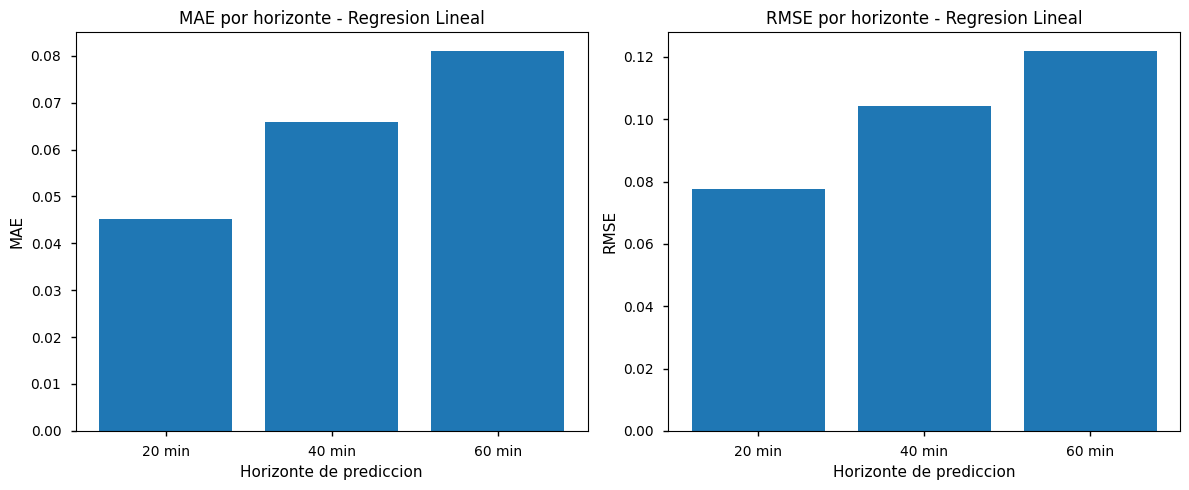

In [11]:
# Graficar metricas por horizonte
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# MAE por horizonte
axes[0].bar(metrics_df['Horizonte'].astype(str) + ' min', metrics_df['MAE'])
axes[0].set_xlabel('Horizonte de prediccion')
axes[0].set_ylabel('MAE')
axes[0].set_title('MAE por horizonte - Regresion Lineal')

# RMSE por horizonte
axes[1].bar(metrics_df['Horizonte'].astype(str) + ' min', metrics_df['RMSE'])
axes[1].set_xlabel('Horizonte de prediccion')
axes[1].set_ylabel('RMSE')
axes[1].set_title('RMSE por horizonte - Regresion Lineal')

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/metrics_by_horizon.png', dpi=300, bbox_inches='tight')
plt.show()


## 7. Analisis de coeficientes

Analisis de importancia de variables mediante los coeficientes del modelo lineal, permitiendo interpretar la contribucion de cada feature a las predicciones.

In [ ]:
# Analizar los coeficientes de cada modelo para interpretar importancia de features
for target, horizon in zip(TARGETS, HORIZONS):
    model = models[target]
    
    # Crear DataFrame con coeficientes y calcular valor absoluto
    coef_df = pd.DataFrame({
        'Feature': FEATURE_COLS,
        'Coeficiente': model.coef_
    })
    coef_df['Abs_Coef'] = np.abs(coef_df['Coeficiente'])
    coef_df = coef_df.sort_values('Abs_Coef', ascending=False)
    
    print(f"\nTop 10 coeficientes (horizonte {horizon} min):")
    print(coef_df.head(10).to_string(index=False))



Top 10 coeficientes (horizonte 20 min):
             Feature  Coeficiente  Abs_Coef
                 ocu    -0.078163  0.078163
           ocu_lag_2     0.053494  0.053494
          ocu_lag_12    -0.044415  0.044415
        ocu_trend_12    -0.034445  0.034445
           ocu_lag_6     0.032955  0.032955
           ocu_lag_1     0.019303  0.019303
         ocu_trend_6     0.015626  0.015626
         ocu_lag_138     0.015219  0.015219
         ocu_trend_2     0.015083  0.015083
station_netflow_rate     0.014459  0.014459

Top 10 coeficientes (horizonte 40 min):
             Feature  Coeficiente  Abs_Coef
           ocu_lag_1     0.098908  0.098908
          ocu_lag_12    -0.088461  0.088461
                 ocu    -0.077202  0.077202
           ocu_lag_2     0.070349  0.070349
        ocu_trend_12    -0.068557  0.068557
           ocu_lag_6    -0.035745  0.035745
         ocu_lag_138     0.033060  0.033060
station_netflow_rate     0.025515  0.025515
         ocu_trend_1     0.022752  0.0

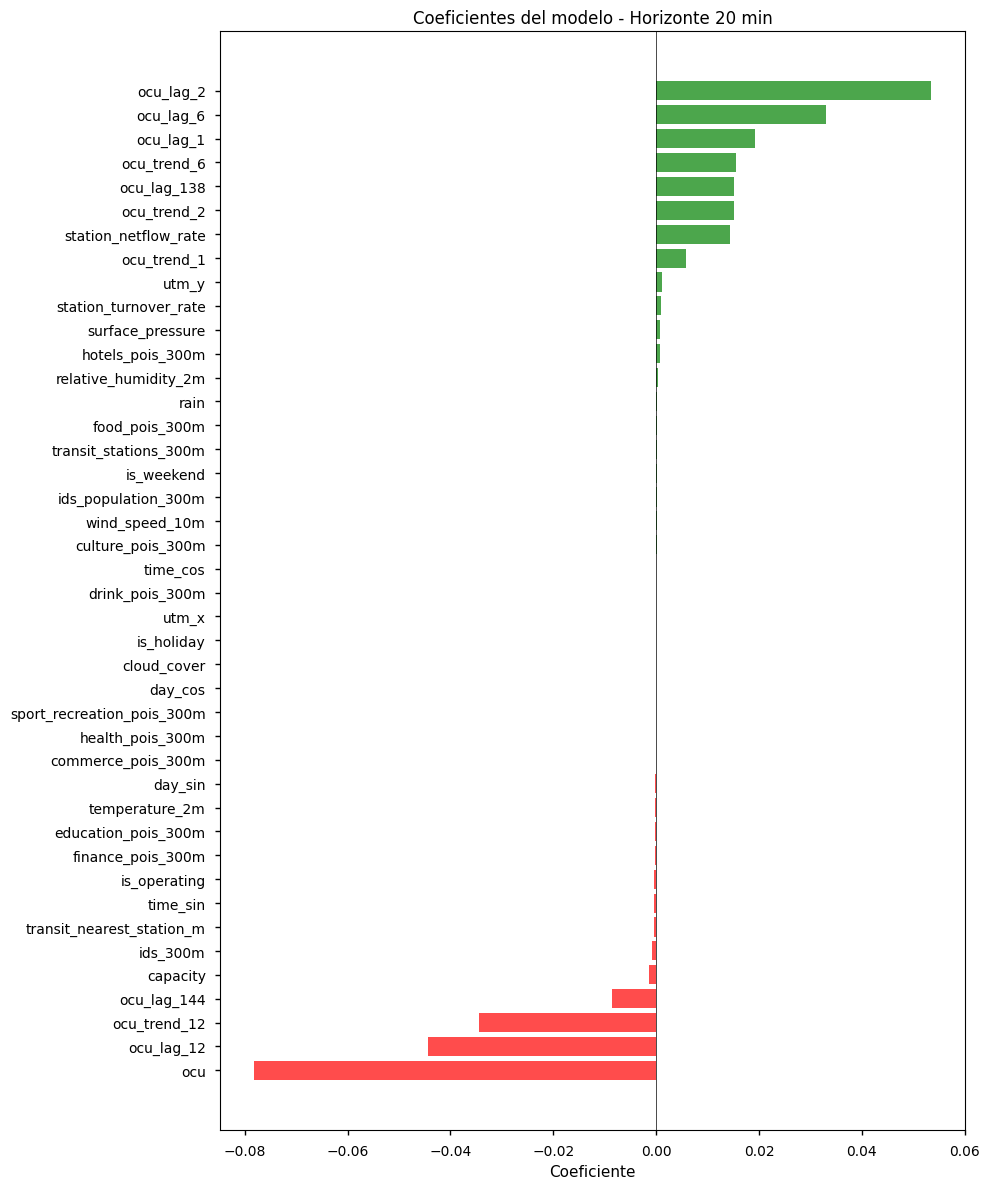

In [ ]:
# Visualizar coeficientes del modelo para horizonte de 20 min
model_20 = models['ocu_delta_20']

# Preparar datos de coeficientes ordenados
coef_df = pd.DataFrame({
    'Feature': FEATURE_COLS,
    'Coeficiente': model_20.coef_
})
coef_df = coef_df.sort_values('Coeficiente')

# Crear grafica de barras horizontales
fig, ax = plt.subplots(figsize=(10, 12))

# Colorear segun signo del coeficiente (rojo=negativo, verde=positivo)
colors = ['red' if c < 0 else 'green' for c in coef_df['Coeficiente']]
ax.barh(coef_df['Feature'], coef_df['Coeficiente'], color=colors, alpha=0.7)
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
ax.set_xlabel('Coeficiente')
ax.set_title('Coeficientes del modelo - Horizonte 20 min')

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/coefficients_20min.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
# Guardar coeficientes de todos los modelos en archivos CSV
for target, horizon in zip(TARGETS, HORIZONS):
    model = models[target]
    
    coef_df = pd.DataFrame({
        'Feature': FEATURE_COLS,
        'Coeficiente': model.coef_
    })
    coef_df['Intercepto'] = model.intercept_
    coef_df.to_csv(f'{OUTPUT_DIR}/coefficients_{horizon}min.csv', index=False)

print(f"Coeficientes guardados en: {OUTPUT_DIR}")


Coeficientes guardados en: output/1_linear_regression



DIAGNOSTICO - COMPARACION CON BASELINE DE PERSISTENCIA

Horizonte 20 min:
  Target - media: 0.000059, std: 0.080741
  Pred   - media: 0.000610, std: 0.021881
  MAE Reg. Lineal:  0.045194
  MAE Persistencia: 0.041512
  Mejora: -8.87%
  Correlacion pred vs real: 0.2783

Horizonte 40 min:
  Target - media: 0.000120, std: 0.112425
  Pred   - media: 0.001242, std: 0.041524
  MAE Reg. Lineal:  0.065933
  MAE Persistencia: 0.062528
  Mejora: -5.45%
  Correlacion pred vs real: 0.3778

Horizonte 60 min:
  Target - media: 0.000182, std: 0.135337
  Pred   - media: 0.001856, std: 0.057911
  MAE Reg. Lineal:  0.080950
  MAE Persistencia: 0.078393
  Mejora: -3.26%
  Correlacion pred vs real: 0.4366

----------------------------------------------------------------------
Distribucion de predicciones:

  20 min:
    |pred| < 0.001: 4.4%
    |pred| < 0.01:  42.9%
    |true| < 0.001: 50.8%
    |true| < 0.01:  50.8%

  40 min:
    |pred| < 0.001: 2.3%
    |pred| < 0.01:  22.8%
    |true| < 0.001: 41.9%
 

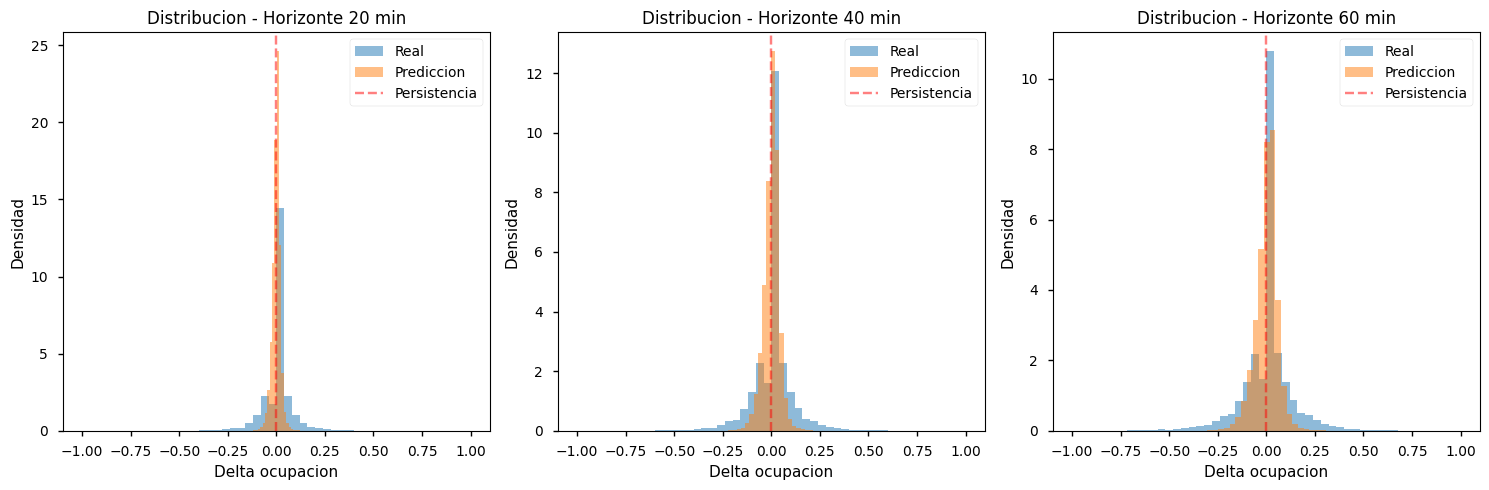

In [ ]:
print("\n" + "=" * 70)
print("DIAGNOSTICO - COMPARACION CON BASELINE DE PERSISTENCIA")
print("=" * 70)

for target, horizon in zip(TARGETS, HORIZONS):
    y_true = y_true_dict[target]
    y_pred_lr = y_pred_dict[target]
    y_pred_naive = np.zeros_like(y_true)
    
    mae_lr = np.mean(np.abs(y_true - y_pred_lr))
    mae_naive = np.mean(np.abs(y_true - y_pred_naive))
    
    corr = np.corrcoef(y_true, y_pred_lr)[0, 1]
    
    print(f"\nHorizonte {horizon} min:")
    print(f"  Target - media: {y_true.mean():.6f}, std: {y_true.std():.6f}")
    print(f"  Pred   - media: {y_pred_lr.mean():.6f}, std: {y_pred_lr.std():.6f}")
    print(f"  MAE Reg. Lineal:  {mae_lr:.6f}")
    print(f"  MAE Persistencia: {mae_naive:.6f}")
    print(f"  Mejora: {((mae_naive - mae_lr) / mae_naive * 100):.2f}%")
    print(f"  Correlacion pred vs real: {corr:.4f}")

print("\n" + "-" * 70)
print("Distribucion de predicciones:")
for target, horizon in zip(TARGETS, HORIZONS):
    y_pred = y_pred_dict[target]
    y_true = y_true_dict[target]
    print(f"\n  {horizon} min:")
    print(f"    |pred| < 0.001: {(np.abs(y_pred) < 0.001).mean()*100:.1f}%")
    print(f"    |pred| < 0.01:  {(np.abs(y_pred) < 0.01).mean()*100:.1f}%")
    print(f"    |true| < 0.001: {(np.abs(y_true) < 0.001).mean()*100:.1f}%")
    print(f"    |true| < 0.01:  {(np.abs(y_true) < 0.01).mean()*100:.1f}%")

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, (target, horizon) in enumerate(zip(TARGETS, HORIZONS)):
    y_true = y_true_dict[target]
    y_pred = y_pred_dict[target]
    
    axes[i].hist(y_true, bins=50, alpha=0.5, label='Real', density=True)
    axes[i].hist(y_pred, bins=50, alpha=0.5, label='Prediccion', density=True)
    axes[i].axvline(x=0, color='red', linestyle='--', alpha=0.5, label='Persistencia')
    axes[i].set_xlabel('Delta ocupacion')
    axes[i].set_ylabel('Densidad')
    axes[i].set_title(f'Distribucion - Horizonte {horizon} min')
    axes[i].legend()

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/diagnostic_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "=" * 70)


In [ ]:
def diagnose_directional_accuracy(y_true, y_pred):
    """
    Calcula el accuracy direccional de las predicciones.
    
    Compara los signos de las predicciones con los valores reales,
    excluyendo casos donde el valor real es cero.
    
    Parameters
    ----------
    y_true : array-like
        Valores reales
    y_pred : array-like
        Valores predichos
    """
    df_diag = pd.DataFrame({'True': y_true, 'Pred': y_pred})
    
    df_active = df_diag[df_diag['True'] != 0].copy()
    
    df_active['Sign_True'] = np.sign(df_active['True'])
    df_active['Sign_Pred'] = np.sign(df_active['Pred'])
    
    da = np.mean(df_active['Sign_True'] == df_active['Sign_Pred'])
    
    print(f"\n=== Diagnostico de direccion ===")
    print(f"Total de muestras evaluadas (sin ceros reales): {len(df_active)}")
    print(f"Directional Accuracy (Filtrado): {da:.2%}")
    
    confusion = pd.crosstab(df_active['Sign_True'], df_active['Sign_Pred'], 
                            rownames=['Realidad'], colnames=['Prediccion'])
    print("\nMatriz de confusion de signos (-1: Bajada, 1: Subida):")
    print(confusion)
    
    if da < 0.4:
        print("\nALERTA: DA < 40%. Posible inversion de signo en el target.")

for i, (target, horizon) in enumerate(zip(TARGETS, HORIZONS)):
    y_true = y_true_dict[target]
    y_pred = y_pred_dict[target]
    diagnose_directional_accuracy(y_true, y_pred)



=== Diagnóstico de Dirección ===
Total de muestras evaluadas (sin ceros reales): 1317399
Directional Accuracy (Filtrado): 62.75%

Matriz de Confusión de Signos (-1: Bajada, 1: Subida):
Predicción    -1.0     1.0
Realidad                  
-1.0        386564  272500
 1.0        218255  440080

=== Diagnóstico de Dirección ===
Total de muestras evaluadas (sin ceros reales): 1556972
Directional Accuracy (Filtrado): 65.13%

Matriz de Confusión de Signos (-1: Bajada, 1: Subida):
Predicción    -1.0     1.0
Realidad                  
-1.0        471488  303569
 1.0        239393  542522

=== Diagnóstico de Dirección ===
Total de muestras evaluadas (sin ceros reales): 1681767
Directional Accuracy (Filtrado): 66.48%

Matriz de Confusión de Signos (-1: Bajada, 1: Subida):
Predicción    -1.0     1.0
Realidad                  
-1.0        515185  318333
 1.0        245327  602922


## 8. Graficas de diagnostico

In [ ]:
# Generar todas las graficas de diagnostico (scatter plots, residuales, etc.)
print("Generando graficas de diagnostico...")
plot_all_diagnostics(
    df_test=test_df,
    y_true_dict=y_true_dict,
    y_pred_dict=y_pred_dict,
    output_dir=OUTPUT_DIR,
    model_name=MODEL_NAME
)


Generando graficas de diagnostico...
  Estaciones seleccionadas:
    Alta actividad: 082
    Baja actividad: 244
    Actividad media: 392
  Generando graficas para horizonte 20 min...
  Generando graficas para horizonte 40 min...
  Generando graficas para horizonte 60 min...
Graficas guardadas en: output/1_linear_regression


## 9. Resumen

In [ ]:
print("=" * 60)
print("RESUMEN - MODELO DE REGRESION LINEAL MULTIPLE")
print("=" * 60)
print(f"\nFeatures utilizadas: {len(FEATURE_COLS)}")
print(f"Escalado: StandardScaler (ajustado solo en train)")
print(f"\nConjuntos de datos:")
print(f"  Entrenamiento: {len(train_df):,} registros")
print(f"  Validacion:    {len(val_df):,} registros")
print(f"  Pruebas:       {len(test_df):,} registros")
print(f"\nMetricas en conjunto de pruebas:")
for _, row in metrics_df.iterrows():
    print(f"  Horizonte {int(row['Horizonte'])} min: MAE={row['MAE']:.6f}, RMSE={row['RMSE']:.6f}, MAE_bikes={row['MAE_bikes']:.2f}")
print(f"\nArchivos guardados en: {OUTPUT_DIR}")
print("=" * 60)


RESUMEN - MODELO DE REGRESION LINEAL MULTIPLE

Features utilizadas: 42
Escalado: StandardScaler (ajustado solo en train)

Conjuntos de datos:
  Entrenamiento: 14,854,057 registros
  Validacion:    2,611,866 registros
  Pruebas:       2,678,212 registros

Metricas en conjunto de pruebas:
  Horizonte 20 min: MAE=0.045194, RMSE=0.077555, MAE_bikes=1.17
  Horizonte 40 min: MAE=0.065933, RMSE=0.104103, MAE_bikes=1.72
  Horizonte 60 min: MAE=0.080950, RMSE=0.121777, MAE_bikes=2.12

Archivos guardados en: output/1_linear_regression
